In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def likelihood(datos, parametros, teoria, desviacion_teoria, modelo):
    '''
    DESCRIPTION: Esta funcion regresa un valor proporcional al likelihood
    IN: datos = las x, variable independiente,
        parametros = parametros del modelo
        teoria = las y, variable dependiente,
        desviacion_teoria = desviacion de las y,
        modelo = funcion que aplica el modelo
    OUT: Numero flotante proporcional al liklihood de los parametros dados
    '''
    #Inicializamos la suma
    suma = 0
    
    #Sumamos cada elemento
    for i in range (len(datos)):
        suma += (teoria[i]-modelo(datos[i], parametros))**2/desviacion_teoria[i]**2
    return -(1/2)*suma


def montecarlo_mc(N, datos, teoria, desviacion_teoria, modelo, desviacion_parametros, p_old, n_pasos=500, seed = 500):
    '''
    REQUIREMENTS: Numpy
    DESCRIPTION: Esta funcion aplica el metodo de montecarlo para obtener los valores
                 mas probables de determinados parametros de un modelo aplicado a
                 ciertos datos conocidos.
    IN: N = numero de cadenas deseadas
        datos = las x, variable independiente,
        teoria = las y, variable dependiente,
        desviacion_teoria = desviacion de las y,
        modelo = funcion que aplica el modelo,
        desviacion_parametros = desviacion estandar conocidas para cada parametro,
        p_old = N aproximaciónes iniciales,
        n_pasos = numero de pasos,
        seed = semilla de numeros aleatorios
    OUT: cadena de markov con likelihoods asociados, y un valor booleano de si el parametro fue aceptado o no,
         esto en cada parametro de la cadena.
    '''
    #Creamos lista donde estarán las cadenas
    markov_matrix = []
    
    #Corremos N veces para obtener n cadenas
    for i_cadena in range(N):
        
        #Para tener datos reproducibles, damos un seed para los numeros aleatorios
        np.random.seed(seed)

        #Inicializamos la cadena de markov
        markov_chain = []

        #agregamos el primer conjunto de parametros y su likelihood
        l_old = likelihood(datos, p_old[i_cadena], teoria, desviacion_teoria, modelo)
        markov_chain.append([p_old[i_cadena], l_old, True])

        #Realizamos n iteraciones
        for paso in range(n_pasos):

            #Lista para nuevo parametro
            p_new = []

            #Llenamos p_new con una distribución aleatoria normal
            for j, parametro in enumerate(p_old[i_cadena]):
                p_new.append(desviacion_parametros[j]*np.random.randn()+parametro)

            #Calculamos nuevo likelihood
            l_new = likelihood(datos, p_new, teoria, desviacion_teoria, modelo)

            #Guardamos nuevo punto, su likelihood y si lo aceptamos o no segun las condiciones
            if (l_new>l_old):
                markov_chain.append([p_new, l_new, True])
                p_old[i_cadena] = p_new
                l_old = l_new
                continue
            #DUDAAAA: aqui se acepta, pero no se renueva la aproximación?
            elif  (np.exp(l_new)/np.exp(l_old) > np.random.randn()):
                markov_chain.append([p_new, l_new, True])
                continue
            else:
                markov_chain.append([p_new, l_new, False])

        else:   
            #Agregamos la cadena de esta iteración a la lista de cadenas
            markov_matrix.append(markov_chain)
            
    else:
        return markov_matrix

In [3]:
# Definimos el modelo que aplicamos, que es una recta
def recta(x, parametros):
    return x*parametros[0]+parametros[1]

#Parametros y sus desviaciones
p_reales = [10, 10]
des_p = [0.1, 0.1]

#Construimos la recta:
x = np.linspace(0, 10, 1000)
y = x*p_reales[0]+p_reales[1]
des_y = [0.1 for punto in range(len(y))]

#Establecemos los N parametros iniciales que usaremos
p_iniciales = [[5, 10],[7, 13], [15, 13], [15, 7], [7, 7]]

#Aplicamos el mcmc
cadenas = montecarlo_mc(N = 5, datos = x, desviacion_teoria = des_y, teoria = y, 
                       modelo = recta, desviacion_parametros = des_p, p_old = p_iniciales, n_pasos = 300)

C:\Users\missa\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars


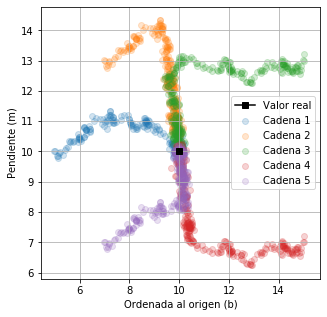

In [4]:
puntos = []
like = []
x = []
y = []

for i, cadena in enumerate(cadenas):
    x.append([])
    y.append([])
    for dato, like, accept in cadena:
        x[i].append(dato[0])
        y[i].append(dato[1])
        
fig, ax0 = fig, ax0 = plt.subplots(figsize=(5, 5))

for i in range(len(cadenas)):
    ax0.scatter(x[i], y[i], marker = 'o', label = 'Cadena '+str(i+1), alpha = 0.2)

plt.plot(p_reales[0], p_reales[1], marker = 's', label = 'Valor real', c = 'black')
ax0.set_ylabel('Pendiente (m)')
ax0.set_xlabel('Ordenada al origen (b)')
ax0.grid()
plt.legend()

plt.show()

In [22]:
#Obtenemos la fraccion de aceptacion de los parametros
ratio = np.zeros(5)
pruebas = len(cadenas[0])

for i in range(5):
    accepted = [c for a, b, c in cadenas[i]]
    ratio[i] = sum(accepted)/pruebas
    
for i, num in enumerate(ratio):
    print(f'Fraccion de aceptacion de la cadena {i}: {num:.3f}')

Fraccion de aceptacion de la cadena 0: 0.415
Fraccion de aceptacion de la cadena 1: 0.239
Fraccion de aceptacion de la cadena 2: 0.329
Fraccion de aceptacion de la cadena 3: 0.365
Fraccion de aceptacion de la cadena 4: 0.372


301